# Gráficas exportadas: método del codo y dispersión

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# interactivo, exportable:
#%matplotlib notebook
# más rápido:
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

dataframes = (pd.read_csv("../data5/dataset_for_clustering.{}.txt".format(day)) for day in ['19may','20may','21may','22may','23may','24may','25may'])
grouped_data = pd.concat(dataframes)
grouped_data.head()

,src_ip,dst_ip,proto,src_port,dst_port,anom_level,threat_level,max_prio,count_events,avg_duration,stdev_duration,night_sessions,work_sessions,afterwork_sessions
0,125.97.1.50,4,0,5,2,0.10,0.0,4,10,54.00,37.69,0,5,0
1,10.181.17.105,6,0,18,2,0.01,0.0,4,38,5.44,1.42,0,18,0
2,172.28.8.10,7,0,8,2,0.03,0.0,4,20,46.75,51.87,0,8,0
3,172.24.108.65,3,0,7,1,0.00,0.0,5,135,29.86,49.94,0,7,0
4,172.28.0.143,22,0,141,2,0.05,0.0,4,283,17.04,27.25,0,141,0


## K-Means

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

x_varnames = [['dst_port','dst_ip'], ['count_events','dst_ip'], ['avg_duration','dst_ip'],
              ['dst_ip','avg_duration','count_events']]

x_vars = []
for n in x_varnames:
    x_vars.append(grouped_data[n].iloc[: , :].values)


all_x_vars = grouped_data.iloc[:, ~grouped_data.columns.isin(['src_ip'])].values

### Selección de K por el método del codo

Por lo visto en la gráfica, se probarán:
- **k=2** y **k=3** para 'dst_port','dst_ip'
- **k=3** y **k=4** para 'count_events','dst_ip'

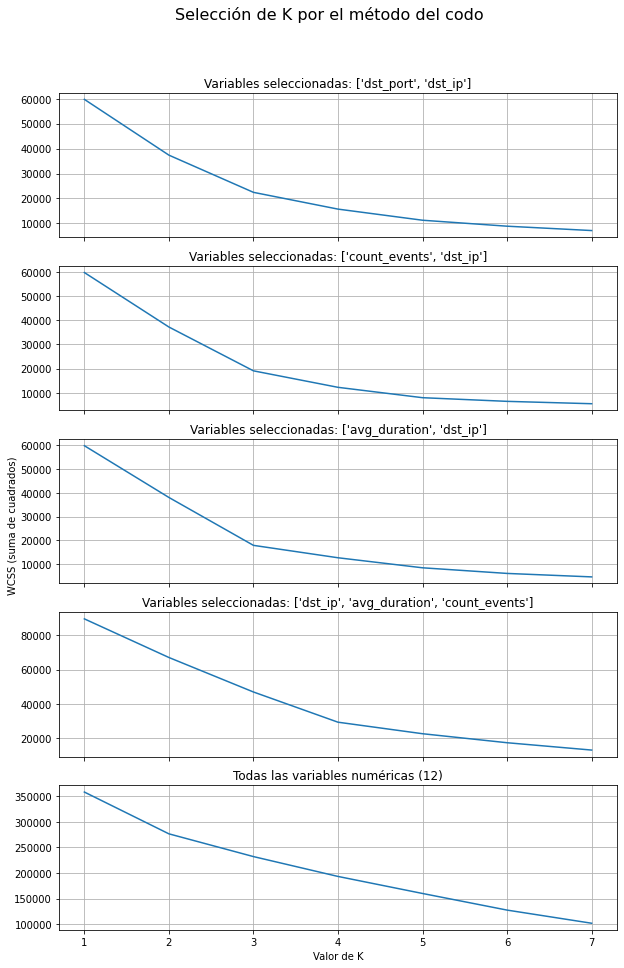

In [3]:
#%%time

fig, axis = plt.subplots(len(x_vars)+1, sharex=True)

for i,x in enumerate(x_vars):
    WCSS = []
    x = StandardScaler().fit_transform(x)
    for k in range(1,8):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x)
        WCSS.append(kmeans.inertia_)

    axis[i].title.set_text('Variables seleccionadas: {}'.format(x_varnames[i]))
    axis[i].plot(range(1,8),WCSS)
    axis[i].grid()

WCSS = []
x = StandardScaler().fit_transform(all_x_vars)
for k in range(1,8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    WCSS.append(kmeans.inertia_)

axis[len(x_vars)].title.set_text('Todas las variables numéricas (12)')
axis[len(x_vars)].plot(range(1,8),WCSS)
axis[len(x_vars)].grid()
    
#plt.ylabel("WCSS (suma de cuadrados)") # suma de las distancias al cuadrado
                                        # entre cada miembro del cluster y su centroide
fig.suptitle("Selección de K por el método del codo", size=16)
fig.text(0.06, 0.5, "WCSS (suma de cuadrados)", ha='center', va='center', rotation='vertical')
fig.set_size_inches(10, 15)
plt.xlabel("Valor de K")

fig.subplots_adjust(top=0.9)

In [ ]:
fig.savefig('codo.pdf', dpi=100)

In [ ]:
########
########
# =>> Parámetros a elegir <<=
###
###

In [4]:
# índice de los x_vars, para probar con una pareja cada vez:

#i = 0 # ['dst_port','dst_ip']
i = 1 # ['count_events','dst_ip']
#i = 2 # ['avg_duration','dst_ip']

# valor de k con el que se está probando:

#k = 2
#k = 3
k = 4

In [ ]:
###
###
########
########

(Código adaptado de [https://www.kaggle.com/burakkahveci/unsupervised-learning-applications](https://www.kaggle.com/burakkahveci/unsupervised-learning-applications))

In [5]:
#%%time

algo = KMeans(n_clusters = k) #,init='k-means++', n_init = 10 ,max_iter=300, 
#                        tol=0.0001,  random_state= 111  , algorithm='elkan')

clusters = algo.fit_predict(x_vars[i])
labels = algo.labels_
centroids = algo.cluster_centers_

In [6]:
#%%time

h = 5 # resolution in the meshgrid. higher h -> lower MemAllocated
x_min, x_max = x_vars[i][:, 0].min() - 1, x_vars[i][:, 0].max() + 1
y_min, y_max = x_vars[i][:, 1].min() - 1, x_vars[i][:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algo.predict(np.c_[xx.ravel(), yy.ravel()])

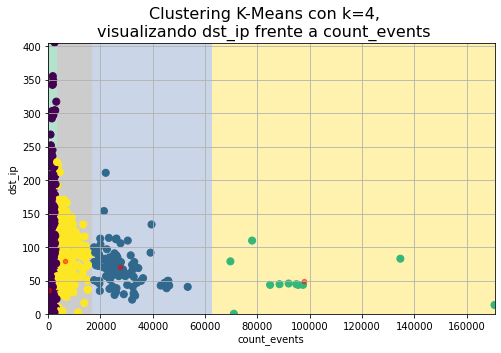

In [7]:
#%%time

fig = plt.figure()
fig.set_size_inches(8, 5)

Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = x_varnames[i][0], y = x_varnames[i][1], data = grouped_data, c = labels, s = 50 )
plt.scatter(x = centroids[: , 0] , y =  centroids[: , 1] , s = 20 , c = 'red' , alpha = 0.5)
plt.ylabel(f'{x_varnames[i][1]}') , plt.xlabel(f'{x_varnames[i][0]}')
plt.grid()
plt.suptitle(f"Clustering K-Means con k={k},\nvisualizando {x_varnames[i][1]} frente a {x_varnames[i][0]}", size=16)
plt.show()

In [ ]:
fig.savefig('dispersion-k4-dst_ip-vs-count_events.pdf', dpi=100)